* [Facial Emotion Recognition with VGG16](#0)
    * [A. Project Introduction](#1)
    * [B. Facial Emotion Recognition](#2)
    * [C. Implementation](#3)
    * [D. Testing and Performance Evaluation](#4)

# **Facial `Emotion` Recognition with `VGG16`** <a id="0"></a>

![Image](https://th.bing.com/th/id/OIP.Blw-iWsVXprzMvQ0s1rXigAAAA?pid=ImgDet&w=152&h=152&c=7&dpr=1.5)


***
***


### **A. Project Introduction** <a id="1"></a>

* In this project, we will build an `AI` system that can `detect` `Facial Emotions` in Human Faces in `Images` and `Videos`.

* We will build this project using `Transfer Learning` with a pre-trained model named `VGG16`.

'''

### **B. `Facial Emotion Recognition` (FER)** <a id="2"></a>

> `Facial emotion recognition` (FER) is a subfield of facial recognition that involves identifying and categorizing `human emotions` based on facial expressions. 

* By analyzing `facial features` and patterns, machines can make educated `guesses` about a person's `emotional state`. This subfield of facial recognition is highly `interdisciplinary`, drawing on insights from `Computer Vision`, machine learning, and psychology. 

![Image](https://i.pinimg.com/originals/b0/bb/1d/b0bb1d0b86bdca1de8ead928064d09d8.png)

The process of FER involves the following steps:

1. **`Face detection`**: The first step is to detect the face in the image or video.

2. **`Facial landmark detection`**: The next step is to identify the facial landmarks such as eyes, nose, mouth, etc.

3. **`Feature extraction`**: The third step is to extract the features from the facial landmarks.

4. **`Classification`**: The final step is to classify the emotion based on the extracted features.

* There are several `datasets` available for FER research, including the **`FER2013`** dataset, which contains `35,887 images` of faces labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral.

'''

### **C. `Implementing` Feature** <a id="3"></a>

* Here, we will be implementing `Facial Emotion Recognition`. 

#### **Task**

* We will `Fine-tune` a `pre-trained` CNN model on a suitable `Dataset` to detect `Facial Emotions` from images of `human beings`.

'''

#### **Dataset - `FER2013`**

* We will use **`FER2013 dataset`** for this task.

* The **`FER2013 dataset`** is a collection of **`Facial Expression images`** that can be used to train and test facial expression recognition algorithms. The dataset contains approximately **`30,000` `facial` `RGB` `images`** of different expressions with size restricted to **`48×48`** pixels. The main labels of the dataset can be divided into 7 types: **`Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral`**. 

* Let's `download` the [FER2013 dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

##### **`Loading` the dataset** 

* We will load the `fer2013.csv` file and read it. 

* In this csv file, each `row` contains a `pixel array` of the `image` and an `emotion label`.

In [2]:
import pandas as pd

data = pd.read_csv('./FER2013_datset/fer2013.csv')

print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


* We see the `emotions` `coloumn` has `numbers` instead of the emotions, that's because these emotions features are `mapped` via `numbers` as such - 

**0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral**

* So, we will create a `emotions features list` to help us find which emotion the `model` detected when it `outputs` out a `number`.

In [3]:
emotions_features = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"] 

##### **`Pre-processing` the `pixel` data**

* The `pixel` column contains a `string` of space-separated `pixel values`. 

* We will convert this `string` into a `NumPy array`. 

* Then we will `normalize` the pixel values (make them fall between 0 and 1) and `reshape` the `array` to the correct dimensions for the `CNN` (`48x48x1`, as the images are `grayscale`).

In [4]:
import numpy as np

pixels = data['pixels'].apply(lambda pixel_sequence: np.fromstring(pixel_sequence, sep=' '))
pixels = np.vstack(pixels.values)
pixels = pixels.reshape(-1, 48, 48, 1)
pixels = pixels.astype('float32')
pixels /= 255  # Normalize pixel values

##### **`Processing` the `labels`**

* The `emotion` column contains the `labels` for the images. 

* These `labels` need to be `converted` into a format that the CNN can understand. 

* We will use the `to_categorical` function from `tensorflow.keras.utils` to convert the labels into `one-hot vectors`.

In [5]:
from keras.utils import to_categorical

emotions = pd.get_dummies(data['emotion']).values

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


##### **`Splitting` the dataset**

* The `FER2013` dataset contains a column called `Usage` that indicates whether a specific image belongs to the `training` set or the `test` set. 

* We will use this column to `split` the `dataset`.

In [6]:
X_train = pixels[data['Usage'] == 'Training']
X_test = pixels[data['Usage'] != 'Training']
y_train = emotions[data['Usage'] == 'Training']
y_test = emotions[data['Usage'] != 'Training']

* The `VGG16` model expects color images (`3 channels`: red, green, blue), but the `FER2013` dataset consists of `grayscale images` (`1` channel).

* For this, we will `convert` all `grayscale` images `to RGB` images by simply duplicating the single grayscale channel three times. 

In [7]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)

#### **Pre-trained Model - `VGG16`**

##### **About - `VGG16`**

* `TensorFlow` provides a `pre-trained` `VGG16` model that you can import and use directly. The model has already been `trained` on the `ImageNet` dataset, which includes a wide variety of images.

![Image](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

* The model has `16 layers` with weights and is considered one of the best vision model architectures. 

* It processes `input` images of size `224x224` with `RGB` channels and `outputs` a `vector of 1000 values` representing the `classification` probability for the corresponding `class`. 

##### **Importing `VGG16` model**

* We will import `VGG16` model from `tensorflow.keras` or `keras` with the weights trained on `imagenet`. 

* We will also `remove` the top (last `classification layer`) and set the `input` shape of `images` to `(48, 48, 3)`.

In [8]:
from keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3)) 

#### **`Adapt` the `VGG16` model**

* The `VGG16` model was originally trained to classify `1000` different `categories`, but we only need it to classify `7` different `emotions`. 

* To do this, we need to `remove` the `last layer` of the model, and then add your own `output layer` with `7` neurons (one for each emotion). 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add Flatten layer
model.add(Flatten())

# Add 'softmax' layer for predictions
model.add(Dense(7, activation='softmax'))

* In the above code, we first create a new `Sequential` model. 

* Then we `iterate` over each of the `layers` in the original `VGG16` model, except for the last layer, and add each layer to the new Sequential model. 

* Finally, we add a `new Dense` layer with `7 outputs` and a `softmax` activation function to the new Sequential model.

#### **Setting `Callbacks`**

* Now we will define `two callbacks` using the `Keras` deep learning library. 

* The first callback is called `LearningRateScheduler` and is used to adjust the `learning rate` of the optimizer during training. 

* The factor `parameter` specifies the `factor` by which the `learning rate` should be `decreased`, and the `every_n_epochs` parameter specifies `how often` the learning rate should be decreased. 

In [10]:
from keras.callbacks import Callback


class LearningRateScheduler(Callback):
    def __init__(self, factor, every_n_epochs):
        super().__init__()
        self.factor = factor
        self.every_n_epochs = every_n_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.every_n_epochs == 0 and epoch != 0:
            lr = float(self.model.optimizer.lr)
            self.model.optimizer.lr = lr * self.factor
            print(f"Learning rate decreased to {lr * self.factor}.")


lr_callback = LearningRateScheduler(factor=0.1, every_n_epochs=10)

* The `second` callback is called `ModelCheckpoint` and is used to `save` the `best model` during training based on a specified metric. 

* In this case, the metric is `val_loss`, which is the `validation loss`. The best model is saved to the file `./Models/best_model.tf`.

In [11]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('./Models/best_model.tf', monitor='val_loss', save_best_only=True)

#### **`Training` the Model**

* We will first `compile` the model in Keras using `Adam` optimizer, use `Categorical Crossentropy` to compute loss, and use `Accuracy` as the evaluation metrics.

In [12]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

* We will now `train` our model for `100` epochs.

In [13]:
model.fit(X_train_rgb, 
          y_train, 
          validation_data=(X_test_rgb, y_test), 
          epochs=100,
          callbacks=[lr_callback, model_checkpoint])

Epoch 1/100
897/898 [============================>.] - ETA: 0s - loss: 1.6027 - accuracy: 0.3784INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 101s 112ms/step - loss: 1.6028 - accuracy: 0.3784 - val_loss: 1.5757 - val_accuracy: 0.3966
Epoch 2/100
897/898 [============================>.] - ETA: 0s - loss: 1.4814 - accuracy: 0.4348INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 102s 113ms/step - loss: 1.4814 - accuracy: 0.4348 - val_loss: 1.5341 - val_accuracy: 0.4269
Epoch 3/100
897/898 [============================>.] - ETA: 0s - loss: 1.4360 - accuracy: 0.4483INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 102s 113ms/step - loss: 1.4360 - accuracy: 0.4483 - val_loss: 1.4933 - val_accuracy: 0.4322
Epoch 4/100
897/898 [============================>.] - ETA: 0s - loss: 1.4050 - accuracy: 0.4633INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 103s 115ms/step - loss: 1.4049 - accuracy: 0.4633 - val_loss: 1.4681 - val_accuracy: 0.4416
Epoch 5/100
898/898 [==============================] - 122s 136ms/step - loss: 1.3809 - accuracy: 0.4776 - val_loss: 1.4937 - val_accuracy: 0.4443
Epoch 6/100
898/898 [==============================] - 120s 134ms/step - loss: 1.3566 - accuracy: 0.4821 - val_loss: 1.4807 - val_accuracy: 0.4455
Epoch 7/100
898/898 [==============================] - 121s 135ms/step - loss: 1.3420 - accuracy: 0.4918 - val_loss: 1.5092 - val_accuracy: 0.4308
Epoch 8/100
897/898 [============================>.] - ETA: 0s - loss: 1.3262 - accuracy: 0.4971INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 120s 134ms/step - loss: 1.3263 - accuracy: 0.4971 - val_loss: 1.4646 - val_accuracy: 0.4483
Epoch 9/100
898/898 [==============================] - 111s 124ms/step - loss: 1.3078 - accuracy: 0.5067 - val_loss: 1.4658 - val_accuracy: 0.4458
Epoch 10/100
898/898 [==============================] - 110s 123ms/step - loss: 1.3028 - accuracy: 0.5069 - val_loss: 1.4689 - val_accuracy: 0.4525
Learning rate decreased to 0.00010000000474974513.
Epoch 11/100
897/898 [============================>.] - ETA: 0s - loss: 1.2215 - accuracy: 0.5467INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 112s 125ms/step - loss: 1.2215 - accuracy: 0.5467 - val_loss: 1.4235 - val_accuracy: 0.4641
Epoch 12/100
897/898 [============================>.] - ETA: 0s - loss: 1.2161 - accuracy: 0.5502INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 112s 125ms/step - loss: 1.2161 - accuracy: 0.5502 - val_loss: 1.4203 - val_accuracy: 0.4650
Epoch 13/100
898/898 [==============================] - 112s 125ms/step - loss: 1.2146 - accuracy: 0.5517 - val_loss: 1.4230 - val_accuracy: 0.4650
Epoch 14/100
898/898 [==============================] - 112s 124ms/step - loss: 1.2131 - accuracy: 0.5507 - val_loss: 1.4257 - val_accuracy: 0.4625
Epoch 15/100
898/898 [==============================] - 111s 124ms/step - loss: 1.2114 - accuracy: 0.5527 - val_loss: 1.4245 - val_accuracy: 0.4628
Epoch 16/100
898/898 [==============================] - 109s 122ms/step - loss: 1.2102 - accuracy: 0.5529 - val_loss: 1.4225 - val_accuracy: 0.4664
Epoch 17/100
898/898 [==============================] - 111s 124ms/step - loss: 1.2096 - accuracy: 0.5521 - val_loss: 1.4208 - val_accuracy: 0.4628
Epoch 18/100
898/898 [==============================] - 112s 125ms/step - loss: 1.2079 - accuracy: 0.5544 - val_loss: 1.4233 

INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 112s 125ms/step - loss: 1.1965 - accuracy: 0.5588 - val_loss: 1.4195 - val_accuracy: 0.4659
Epoch 23/100
898/898 [==============================] - 115s 128ms/step - loss: 1.1962 - accuracy: 0.5596 - val_loss: 1.4197 - val_accuracy: 0.4668
Epoch 24/100
898/898 [==============================] - 113s 126ms/step - loss: 1.1961 - accuracy: 0.5596 - val_loss: 1.4198 - val_accuracy: 0.4653
Epoch 25/100
898/898 [==============================] - 114s 127ms/step - loss: 1.1958 - accuracy: 0.5598 - val_loss: 1.4201 - val_accuracy: 0.4671
Epoch 26/100
897/898 [============================>.] - ETA: 0s - loss: 1.1956 - accuracy: 0.5615INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 113s 126ms/step - loss: 1.1956 - accuracy: 0.5615 - val_loss: 1.4191 - val_accuracy: 0.4671
Epoch 27/100
898/898 [==============================] - 107s 119ms/step - loss: 1.1956 - accuracy: 0.5603 - val_loss: 1.4193 - val_accuracy: 0.4654
Epoch 28/100
897/898 [============================>.] - ETA: 0s - loss: 1.1955 - accuracy: 0.5601INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


INFO:tensorflow:Assets written to: ./Models\best_model.tf\assets


898/898 [==============================] - 108s 120ms/step - loss: 1.1955 - accuracy: 0.5601 - val_loss: 1.4189 - val_accuracy: 0.4650
Epoch 29/100
898/898 [==============================] - 127s 142ms/step - loss: 1.1953 - accuracy: 0.5600 - val_loss: 1.4196 - val_accuracy: 0.4659
Epoch 30/100
898/898 [==============================] - 119s 132ms/step - loss: 1.1952 - accuracy: 0.5608 - val_loss: 1.4195 - val_accuracy: 0.4657
Learning rate decreased to 1.0000000656873453e-06.
Epoch 31/100
898/898 [==============================] - 113s 126ms/step - loss: 1.1943 - accuracy: 0.5614 - val_loss: 1.4193 - val_accuracy: 0.4650
Epoch 32/100
898/898 [==============================] - 107s 119ms/step - loss: 1.1942 - accuracy: 0.5609 - val_loss: 1.4192 - val_accuracy: 0.4646
Epoch 33/100
898/898 [==============================] - 108s 121ms/step - loss: 1.1942 - accuracy: 0.5601 - val_loss: 1.4192 - val_accuracy: 0.4645
Epoch 34/100
898/898 [==============================] - 109s 121ms/step - 

'''

### **D. `Testing` and `Performance` `Evaluation`** <a id="4"></a>

* Let's see how well our model performs.

#### **Model Evaluation on Test Dataset**

* First things first, we will `Evaluate` our model on a `Test Dataset`.

*  And we do it by `Importing Best Model`, then evaluating on `Test` Dataset.

In [14]:
from keras.models import load_model

model = load_model('./Models/best_model.tf')


loss, accuracy = model.evaluate(X_test_rgb, y_test)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

225/225 [==============================] - 21s 91ms/step - loss: 1.4189 - accuracy: 0.4650
Test loss: 1.4189471006393433
Test accuracy: 0.46503204107284546


* An accuracy of `46.5 %`. 

* `Not so good`. Big room for `improvement`.

* But considering the `best accuracy` on the Dataset way `73.7 %`, we can consider this model `half good`.

#### **Results on Image**

* We will first test to see how the model performs on `image` data.

* Below is the `features` list.

In [27]:
emotions_features = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"] 

* In the code below, we define a function named `predict_emotion` which takes in an `image` and print out the `Recognized Emotion.`

Here's how the function works: 

* The function `predict_emotion(image)` takes an `image` file path as input.

* It loads the image in `grayscale` mode and resizes it to a fixed size of **48x48 pixels**.

* The image is converted to a **numpy array** and normalized by dividing pixel values by `255` (similar to the training data).

* To match the expected `input shape` for a neural network, the `2D` grayscale image is `transformed` into a `3D RGB` image by repeating the same channel three times.

* An extra `dimension` is added to represent the batch size (necessary for model prediction).

* The trained model is used to `predict` the `emotion` of the image. The predictions are probabilities for each of the **7 emotions** (e.g., anger, fear, happiness).

* The highest probability index is extracted using `argmax`, and the corresponding emotion label is printed as the predicted emotion.

In [19]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np


def predict_emotion(image):
    
    img = load_img(image, color_mode='grayscale', target_size=(48, 48))

    img_array = img_to_array(img)
    img_array /= 255
    img_array = np.repeat(img_array, 3, -1)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_emotion = np.argmax(predictions[0])

    print(f'The predicted emotion is: {emotions_features[predicted_emotion]}')

* And below is a function to `display` the `image`.

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image):
    img = mpimg.imread(image)
    plt.imshow(img)
    plt.show()

* Let's make predictions on image one by one.

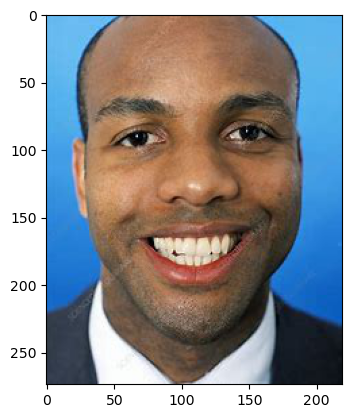

1/1 [==============================] - 0s 27ms/step
The predicted emotion is: Happy


In [21]:
image = "./test_1.jpg"

display_image(image=image)
predict_emotion(image=image)

* `Happy!`

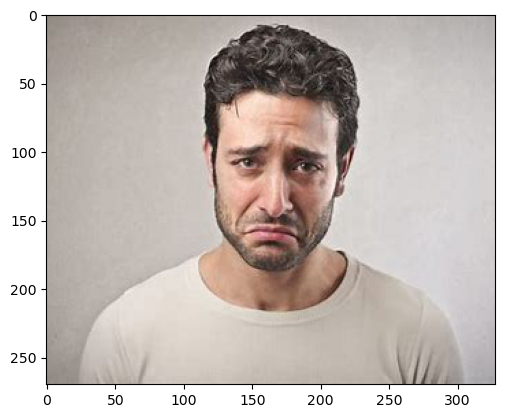

1/1 [==============================] - 0s 24ms/step
The predicted emotion is: Sad


In [25]:
image = "./test_2.jpg"

display_image(image=image)
predict_emotion(image=image)

* `Sad`!

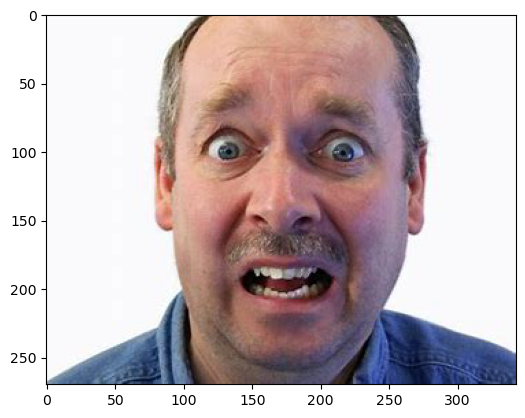

1/1 [==============================] - 0s 24ms/step
The predicted emotion is: Fear


In [26]:
image = "./test_3.jpg"

display_image(image=image)
predict_emotion(image=image)

* `Fear@!`

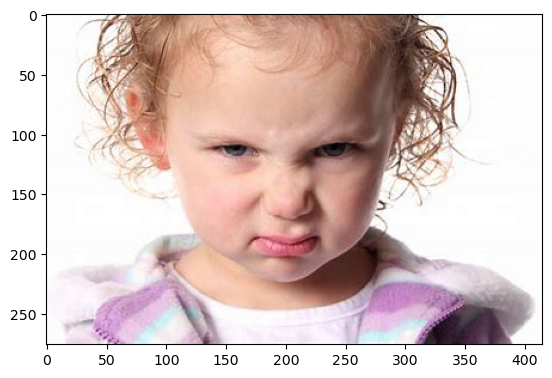

1/1 [==============================] - 0s 27ms/step
The predicted emotion is: Happy


In [30]:
image = "./test_4.jpg"

display_image(image=image)
predict_emotion(image=image)

* `Happy ?` Oop!s

* That girl looks anything but happy. 

* Well the model is still far from perfect.


#### **`Live` Performance on a `Video`**

* Let's now, see evaluate the `model's` performance on a `Video`.

* We will start by `loading` the `best model`.

In [1]:
from keras.models import load_model

model = load_model('./Models/best_model.tf')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


* Then load the `features list`.

In [2]:
emotions_features = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  

* Now, one thing we will add here, is that we will be using `Haar Cascade` from `OpenCV`.



##### **What is `Haar Cascade` ?**

> **Haar Cascades** are machine learning object detection algorithms. 

* They use **Haar features** to determine the likelihood of a certain point being part of an object. These features involve calculations performed on adjacent rectangular regions within a detection window. 

* The algorithm then uses **boosting techniques** to combine these "weak" learners into a strong prediction. 

> **Haar cascades** have been widely used for tasks like **face detection**, where they analyze patterns in an image or video to identify specific objects or regions of interest. 

##### **Implementing `Facial Emotion Recognition` with `Haar Cascade`**

* First, we will load **Haar Cascade** for `Face Detection` from **OpenCV** library.

In [3]:
import cv2 

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

* And below, we take a `video` and iterate through it's every frame, `pre-process` it as before, and `predict` emotions.


Here's how it works : 

1. **Video Capture Initialization**:
    - The code starts by initializing video capture from a file named `'test_video_1.mp4'`.
    - The `cv2.VideoCapture` class is used to read frames from the video file.
    - Replace `file name` wih `0` incase you wish to use the `WebCam`.

2. **Frame Processing Loop**:
    - The `while True` loop processes each frame of the video.
    - It reads the next frame using `cap.read()`.
    - Converts the frame from BGR to grayscale using `cv2.cvtColor`.
    - Detects faces in the grayscale frame using the Haar cascade classifier (`face_cascade.detectMultiScale`).
    - If a face is detected, it proceeds with further steps.

3. **Face Region Extraction and Preprocessing**:
    - Extracts the first detected face's coordinates `(x, y, w, h)`.
    - Creates a region of interest (ROI) containing the face in grayscale (`face_roi`).
    - Resizes the `face_roi` to 48x48 pixels.
    - Converts the grayscale face region to RGB format.
    - Normalizes the pixel values to the range [0, 1].

4. **Emotion Prediction**:
    - Adds an extra dimension to the RGB image for batch size and channels.
    - Uses a pre-trained model (`model`) to predict the emotion label for the face.
    - The predicted emotion index is obtained using `np.argmax(predictions[0])`.

5. **Visual Feedback**:
    - The predicted emotion label is displayed on the frame using `cv2.putText`.
    - A rectangle is drawn around the detected face using `cv2.rectangle`.

6. **Display and Exit**:
    - The resulting frame with emotion information is displayed using `cv2.imshow`.
    - The loop continues until the user presses the 'q' key.
    - After exiting the loop, the video capture is released, and windows are destroyed.


In [ ]:
import numpy as np


cap = cv2.VideoCapture('test_video_1.mp4')

while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        
        face_roi = gray[y:y + h, x:x + w]
        face_roi = cv2.resize(face_roi, (48, 48))
        
        rgb = cv2.cvtColor(face_roi, cv2.COLOR_GRAY2RGB)
        rgb = rgb / 255.0
        rgb = np.expand_dims(rgb, axis=(0, -1))

        predictions = model.predict(rgb)
        predicted_emotion = np.argmax(predictions[0])

        cv2.putText(frame, str(emotions_features[predicted_emotion]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

* Well it seems the `model` is `capable` and `fast` enough to perform on `video` feeds.

* This concludes **`Audience Watches`** feature. 

* Let's move on to the next one.

***
*** 